## Projeto 2-2: Contagem de Pessoas

Gabriel Moreira

### Rubrica do Projeto:

    I. Não entregou ou entregou apenas um rascunho.
    D. Implementou parcialmente o artigo ou não realizou a contagem.
    C. Implementou a sessão 2 do artigo e realizou uma contagem de forma simples.
    B. Cumpriu a rubrica C com a implementação completa do codebook.
    A. Além de cumprir a rubrica B, realiza a contagem com uma técnica elaborada.
    
    -1 Conceito se o relatório estiver ausente ou insatisfatório.

# Introdução

# 1° Parte - Subtração do background

# 2° Parte - Tratamento do resultado

# 3° Parte - Contagem de pessoas 

In [298]:
%reset -f
%matplotlib inline
import pickle
import matplotlib.pyplot as plt
import time
import cv2 as cv
import numpy as np
import random

epsilon = 10
alpha = 0.4    # 0.4 - 0.7
beta = 1.1     # 1.1 - 1.5
rows, cols = 576, 768



def create_codebook_matrix(rows, cols):
    matrix = []
    for i in range(rows):
        matrix.append([])
        for j in range(cols):
            matrix[i].append([])
    return matrix

def get_path_image(dataset, view, time, number):
    if dataset == "background":
        str_number = '0' * (8-len(str(number))) + str(number)
        path_image = f"./Crowd_PETS09/S0/Background/View_00{view}/Time_{time}/{str_number}.jpg"
    elif dataset == "city center":
        str_number =  'frame_'+ '0' * (4-len(str(number))) + str(number)
        path_image = f"./Crowd_PETS09-1/S0/City_Center/Time_{time}/View_00{view}/{str_number}.jpg"  
    else:
        str_number =  'frame_'+ '0' * (4-len(str(number))) + str(number)
        path_image = f"./Crowd_PETS09-2/S1/L1/Time_{time}/View_00{view}/{str_number}.jpg"
    return path_image     

def create_random_images_list(number_of_images, dataset="background"):
    if(dataset == "background"):
        time_list = ["13-06", "13-19", "13-32", "13-38"]
        matrix = []
        for j in range(4):
            matrix.append([])
        for i in range(number_of_images):
            image_number = random.randint(0, 446)
            image_time = random.randint(0, 4) - 1
            matrix[image_time].append(image_number)
    elif dataset == "city center":
        time_list = ["12-34", "14-55"]
        matrix = []
        for j in range(2):
            matrix.append([])
        for i in range(number_of_images):
            image_number = random.randint(0, 794)
            image_time = random.randint(0, 2) - 1
            matrix[image_time].append(image_number)
    else:
        time_list = ["13-57", "13-59"]
        matrix = []
        for j in range(2):
            matrix.append([])
        for i in range(number_of_images):
            image_number = random.randint(0, 220)
            image_time = random.randint(0, 2) - 1
            matrix[image_time].append(image_number) 
    print(matrix, time_list)
    return matrix, time_list

def create_codeword(R, G, B, i_min, i_max, f, _lambda, p, q):
    return [R, G, B, i_min, i_max, f, _lambda, p, q]

def calculate_brightness(R, G, B):
    return ((R ** 2) + (G ** 2) + (B ** 2)) ** 0.5

def calculate_color_dist(x, v):
    xt2 = (x[0] ** 2) + (x[1] ** 2) + (x[2] ** 2)
    vi2 = (v[0] ** 2) + (v[1] ** 2) + (v[2] ** 2)
    dot_product2 = ((v[0] * x[0]) + (v[1] * x[1]) + (v[2] * x[2])) ** 2
    if(vi2 == 0):
        return abs(xt2) ** 0.5
    p2 = dot_product2 / (vi2)
    return abs(xt2 - p2) ** 0.5

def calculate_high_low_brightness(alpha, beta, i_max, i_min):
    i_low = alpha * i_max
    i_high = min(beta* i_max, (i_min/alpha))
    return i_low, i_high

def brightness(I, i_low, i_high):
    return (i_low <= I <= i_high)

def construct_codebook(pixel, t, codebook):
    R = pixel[0]
    G = pixel[1]
    B = pixel[2]
    I = calculate_brightness(R, G, B)
    i_max = I
    i_min = I
    matched = False
    for codeword in codebook:
        color_dist = calculate_color_dist([R, G, B], [codeword[0], codeword[1], codeword[2]])
        i_low, i_high = calculate_high_low_brightness(alpha, beta, codeword[3], codeword[4])
        b = brightness(I, i_low, i_high) 
        if((color_dist <= epsilon) and b):
            new_R = ((codeword[5] * codeword[0]) + R)/ (codeword[5] + 1)
            new_G = ((codeword[5] * codeword[1]) + G)/ (codeword[5] + 1)
            new_B = ((codeword[5] * codeword[2]) + B)/ (codeword[5] + 1)
            codeword[0] = new_R
            codeword[1] = new_G
            codeword[2] = new_B
            codeword[4] = max(I, codeword[4])
            codeword[3] = min(I, codeword[3])
            codeword[5] +=1
            codeword[6] = max(codeword[6], t - codeword[8])
            codeword[8] = t
            matched = True
            break
    if not matched:
        new_codeword = create_codeword(R, G, B, I, I, 1, t - 1, t, t)
        codebook.append(new_codeword)
    return codebook

def adjust_lambda(matrix_codebooks, number_of_images = 40):
    for i in range(len(matrix_codebooks)):
        for j in range(len(matrix_codebooks[i])):
            for codeword in matrix_codebooks[i][j]:
                codeword[6] = max(codeword[6], (number_of_images - codeword[8] + codeword[7] - 1))
    return matrix_codebooks

def clean_file(filepath, number_of_images):
    pickle_in = open(filepath,"rb")
    matrix_codebooks = pickle.load(pickle_in)

    new_matrix = create_codebook_matrix(rows, cols)

    for i in (range(len(matrix_codebooks))):
        for j in range(len(matrix_codebooks[i])):
            for codeword in matrix_codebooks[i][j]:
                _lambda = codeword[6]
                if(_lambda <= number_of_images/2):
                    new_matrix[i][j].append(codeword)

    pickle_out = open("codebook_clean.pickle","wb")
    pickle.dump(new_matrix, pickle_out)
    pickle_out.close()

    
def train (view, dataset, number_of_images):
    start = time.time()
    print("Training...")
    image_list, time_list = create_random_images_list(TRAINING_IMAGES, DATASET)
    matrix_codebooks = create_codebook_matrix(rows, cols)
    image_index = 1
    for k in (range(len(time_list))):
        for l in (range(len(image_list[k]))):
            print("-" * 16)
            print(f"IMAGE: {image_index}")
            path_image = get_path_image(DATASET, VIEW, time_list[k], image_list[k][l])
            print(path_image)
            image = cv.imread(path_image)
            image = image.astype(float)
            st = time.time()
            for i in range(rows):
                for j in range(cols):
                    pixel = image[i][j]
                    actual_codebook = matrix_codebooks[i][j]
                    new_codebook = construct_codebook(pixel, image_index, actual_codebook)
                    matrix_codebooks[i][j] = new_codebook
            en = time.time()
            print(f"Time: {en-st}")
            image_index+=1


    matrix_codebooks = adjust_lambda(matrix_codebooks, TRAINING_IMAGES)
    end = time.time()
    print("TIME: {}".format(end-start))
    return matrix_codebooks


In [277]:
def test(pixel, t, i, j, matrix_codebooks):
    R = pixel[0]
    G = pixel[1]
    B = pixel[2]
    I = calculate_brightness(R, G, B)
    i_max = I
    i_min = I
    index = 0
    codebook = matrix_codebooks[i][j]
    matched = False
    for codeword in codebook:
        color_dist = calculate_color_dist([R, G, B], [codeword[0], codeword[1], codeword[2]])
        i_low, i_high = calculate_high_low_brightness(alpha, beta, codeword[3], codeword[4])
        b = brightness(I, i_low, i_high) 
        if((color_dist <= epsilon) and b):
            matched = True
            result = [0,0,0]
            break
    if(matched ==  False):
        result = [255,255,255]
        
    return result


def test2(pixel, t, i, j, matrix_codebooks):
    R = pixel[0]
    G = pixel[1]
    B = pixel[2]
    I = calculate_brightness(R, G, B)
    i_max = I
    i_min = I
    matched = False
    codebook = matrix_codebooks[i][j]
    for codeword in codebook:
        color_dist = calculate_color_dist([R, G, B], [codeword[0], codeword[1], codeword[2]])
        i_low, i_high = calculate_high_low_brightness(alpha, beta, codeword[3], codeword[4])
        b = brightness(I, i_low, i_high) 
        if((color_dist <= epsilon) and b):
            new_R = ((codeword[5] * codeword[0]) + R)/ (codeword[5] + 1)
            new_G = ((codeword[5] * codeword[1]) + G)/ (codeword[5] + 1)
            new_B = ((codeword[5] * codeword[2]) + B)/ (codeword[5] + 1)
            codeword[0] = new_R
            codeword[1] = new_G
            codeword[2] = new_B
            codeword[4] = max(I, codeword[4])
            codeword[3] = min(I, codeword[3])
            codeword[5] +=1
            codeword[6] = max(codeword[6], t - codeword[8])
            codeword[8] = t
            matched = True
            result = [0, 0, 0]
            break
    if not matched:
        result = [255, 255, 255]
    return codebook, result

In [278]:
import imutils
from imutils import perspective
from imutils import contours

def subtract(dataset, view, time1, image_number, matrix_codebooks):
    start = time.time()
    path_image = get_path_image(dataset, view, time1, image_number)
    image = cv.imread(path_image)
    image = image.astype(float)
    image_copy = image.copy()
    for i in range(rows):
        for j in range(cols):
            actual = image[i][j]
            new_codebook, new_pixel = test2(actual, image_number, i, j, matrix_codebooks)
            new_codebook = matrix_codebooks[i][j]
            image_copy[i][j] = new_pixel
    plt.imshow(np.uint8(image_copy))
    plt.show()
    end = time.time()
    print("TIME: {}".format(end-start))
    return (image_copy, image, matrix_codebooks)

def count(image, sub):
    kernel = np.ones((7,7),np.uint8)
    erosion = cv.erode(sub,kernel,iterations = 1)
    dilation = cv.dilate(erosion,kernel,iterations = 2)
    blur = cv.blur(dilation,(7,7))
#     plt.imshow(blur)
    params = cv.SimpleBlobDetector_Params()
#     params.filterByInertia = True
#     params.maxInertiaRatio = 0.7
    params.filterByConvexity = False
    params.filterByArea = True
    params.minArea = 300
#     params.maxArea = 1000
    detector = cv.SimpleBlobDetector_create(params) 
    reversemask = 255-np.uint8(blur)
    keypoints = detector.detect(reversemask)
    im_with_keypoints = cv.drawKeypoints(np.uint8(image), keypoints, np.array([]), (0,255,0), cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.imshow(im_with_keypoints)
    print(f"A imagem possui {len(keypoints)} pessoa(s)")
    

    

# Background


## Treino

In [279]:
VIEW = 1
DATASET = "background"
TRAINING_IMAGES = 10

matrix_codebooks = train(VIEW, DATASET, TRAINING_IMAGES)
pickle_out = open("codebook_background.pickle","wb")
pickle.dump(matrix_codebooks, pickle_out)
pickle_out.close()
print("File Created")
clean_file("codebook_background.pickle", TRAINING_IMAGES)

Training...
[[382, 7, 288], [53, 208, 258, 9, 371], [], [71, 191]] ['13-06', '13-19', '13-32', '13-38']
----------------
IMAGE: 1
./Crowd_PETS09/S0/Background/View_001/Time_13-06/00000382.jpg
Time: 1.2756037712097168
----------------
IMAGE: 2
./Crowd_PETS09/S0/Background/View_001/Time_13-06/00000007.jpg
Time: 5.110612154006958
----------------
IMAGE: 3
./Crowd_PETS09/S0/Background/View_001/Time_13-06/00000288.jpg
Time: 8.042403221130371
----------------
IMAGE: 4
./Crowd_PETS09/S0/Background/View_001/Time_13-19/00000053.jpg
Time: 6.276429891586304
----------------
IMAGE: 5
./Crowd_PETS09/S0/Background/View_001/Time_13-19/00000208.jpg
Time: 7.617147207260132
----------------
IMAGE: 6
./Crowd_PETS09/S0/Background/View_001/Time_13-19/00000258.jpg
Time: 8.591567993164062
----------------
IMAGE: 7
./Crowd_PETS09/S0/Background/View_001/Time_13-19/00000009.jpg
Time: 7.838824033737183
----------------
IMAGE: 8
./Crowd_PETS09/S0/Background/View_001/Time_13-19/00000371.jpg
Time: 8.641646146774292

In [280]:
epsilon = 12
alpha = 0.6    # 0.4 - 0.7
beta = 1.5     # 1.1 - 1.5
rows, cols = 576, 768

# VIEW = 1
# DATASET = "background"
# TRAINING_IMAGES = 10

pickle_in = open("codebook_background.pickle","rb")
matrix_codebooks = pickle.load(pickle_in)

## Resultados

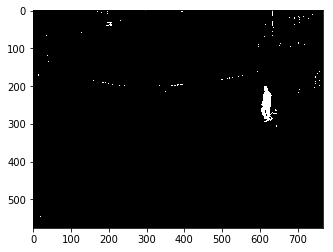

TIME: 7.8926918506622314
A imagem possui 1 pessoa(s)


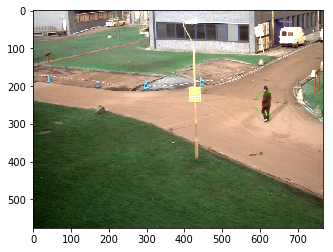

In [281]:
result, image, matrix_codebooks = subtract(DATASET, VIEW, "13-19", 338, matrix_codebooks)
count(image, result)

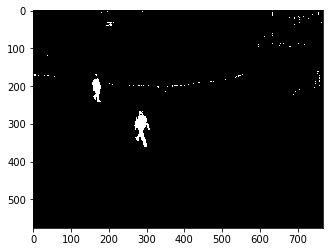

TIME: 8.568332195281982
A imagem possui 2 pessoa(s)


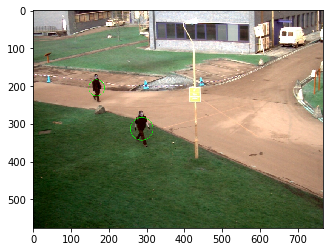

In [282]:
result, image, matrix_codebooks = subtract(DATASET, VIEW, "13-19", 150, matrix_codebooks)
count(image, result)

# City center

## Treino

In [283]:
VIEW = 1
DATASET = "city center"
TRAINING_IMAGES = 10

matrix_codebooks = train(VIEW, DATASET, TRAINING_IMAGES)
pickle_out = open("codebook_city_center.pickle","wb")
pickle.dump(matrix_codebooks, pickle_out)
pickle_out.close()
print("File Created")
clean_file("codebook_city_center.pickle", TRAINING_IMAGES)

Training...
[[500, 775], [603, 413, 732, 518, 376, 246, 504, 343]] ['12-34', '14-55']
----------------
IMAGE: 1
./Crowd_PETS09-1/S0/City_Center/Time_12-34/View_001/frame_0500.jpg
Time: 1.115684986114502
----------------
IMAGE: 2
./Crowd_PETS09-1/S0/City_Center/Time_12-34/View_001/frame_0775.jpg
Time: 4.034435033798218
----------------
IMAGE: 3
./Crowd_PETS09-1/S0/City_Center/Time_14-55/View_001/frame_0603.jpg
Time: 3.9753029346466064
----------------
IMAGE: 4
./Crowd_PETS09-1/S0/City_Center/Time_14-55/View_001/frame_0413.jpg
Time: 6.8208208084106445
----------------
IMAGE: 5
./Crowd_PETS09-1/S0/City_Center/Time_14-55/View_001/frame_0732.jpg
Time: 6.566361904144287
----------------
IMAGE: 6
./Crowd_PETS09-1/S0/City_Center/Time_14-55/View_001/frame_0518.jpg
Time: 6.169226884841919
----------------
IMAGE: 7
./Crowd_PETS09-1/S0/City_Center/Time_14-55/View_001/frame_0376.jpg
Time: 6.176898956298828
----------------
IMAGE: 8
./Crowd_PETS09-1/S0/City_Center/Time_14-55/View_001/frame_0246.jpg


In [284]:
VIEW = 1
DATASET = "city center"

epsilon = 12
alpha = 0.6    # 0.4 - 0.7
beta = 1.5     # 1.1 - 1.5
rows, cols = 576, 768

pickle_in = open("codebook_city_center.pickle","rb")
matrix_codebooks = pickle.load(pickle_in)

## Resultados

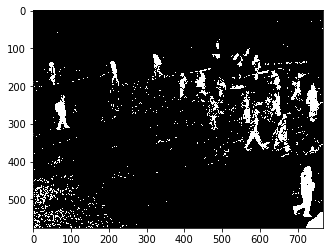

TIME: 7.100095987319946
A imagem possui 23 pessoa(s)


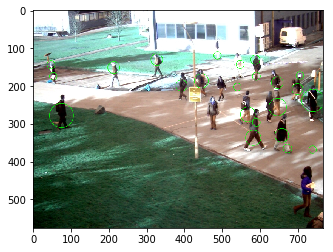

In [285]:
result, image, matrix_codebooks = subtract(DATASET, VIEW, "14-55", 140, matrix_codebooks)
count(image, result)

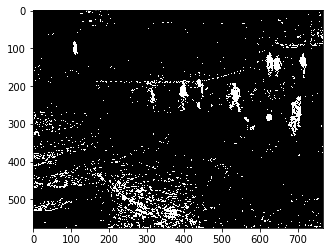

TIME: 5.722254276275635
A imagem possui 11 pessoa(s)


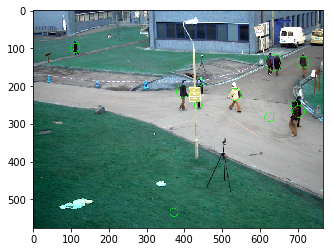

In [286]:
result, image, matrix_codebooks = subtract(DATASET, VIEW, "12-34", 140, matrix_codebooks)
count(image, result)

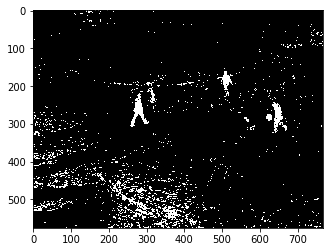

TIME: 5.609766244888306
A imagem possui 5 pessoa(s)


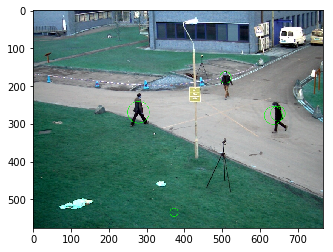

In [287]:
result, image, matrix_codebooks = subtract(DATASET, VIEW, "12-34", 2, matrix_codebooks)
count(image, result)

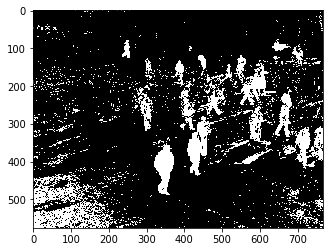

TIME: 7.115871906280518
A imagem possui 21 pessoa(s)


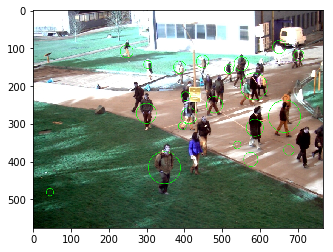

In [288]:
result, image, matrix_codebooks = subtract(DATASET, VIEW, "14-55", 100, matrix_codebooks)
count(image, result)

# Crowd

## Treino

In [293]:
VIEW = 1
DATASET = "crowd"
TRAINING_IMAGES = 10

matrix_codebooks = train(VIEW, DATASET, TRAINING_IMAGES)
pickle_out = open("codebook_crowd.pickle","wb")
pickle.dump(matrix_codebooks, pickle_out)
pickle_out.close()
print("File Created")
clean_file("codebook_crowd.pickle", TRAINING_IMAGES)

Training...
[[188, 108, 16, 33, 11, 143], [65, 53, 136, 90]] ['13-57', '13-59']
----------------
IMAGE: 1
./Crowd_PETS09-2/S1/L1/Time_13-57/View_001/frame_0188.jpg
Time: 3.0133981704711914
----------------
IMAGE: 2
./Crowd_PETS09-2/S1/L1/Time_13-57/View_001/frame_0108.jpg
Time: 4.15952730178833
----------------
IMAGE: 3
./Crowd_PETS09-2/S1/L1/Time_13-57/View_001/frame_0016.jpg
Time: 4.2482500076293945
----------------
IMAGE: 4
./Crowd_PETS09-2/S1/L1/Time_13-57/View_001/frame_0033.jpg
Time: 4.203993797302246
----------------
IMAGE: 5
./Crowd_PETS09-2/S1/L1/Time_13-57/View_001/frame_0011.jpg
Time: 4.310622930526733
----------------
IMAGE: 6
./Crowd_PETS09-2/S1/L1/Time_13-57/View_001/frame_0143.jpg
Time: 4.370569944381714
----------------
IMAGE: 7
./Crowd_PETS09-2/S1/L1/Time_13-59/View_001/frame_0065.jpg
Time: 3.867751359939575
----------------
IMAGE: 8
./Crowd_PETS09-2/S1/L1/Time_13-59/View_001/frame_0053.jpg
Time: 6.757447004318237
----------------
IMAGE: 9
./Crowd_PETS09-2/S1/L1/Time_1

In [294]:
epsilon = 12
alpha = 0.6    # 0.4 - 0.7
beta = 1.5     # 1.1 - 1.5
rows, cols = 576, 768

# VIEW = 1
# DATASET = "background"
# TRAINING_IMAGES = 10

pickle_in = open("codebook_crowd.pickle","rb")
matrix_codebooks = pickle.load(pickle_in)

## Resultado

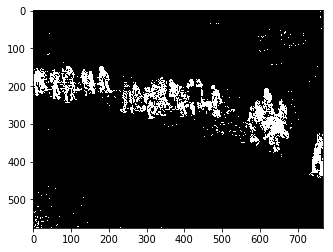

TIME: 5.372092247009277
A imagem possui 21 pessoa(s)


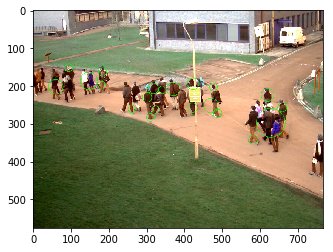

In [295]:
result, image, matrix_codebooks = subtract(DATASET, VIEW, "13-57", 130, matrix_codebooks)
count(image, result)

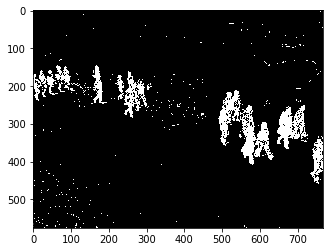

TIME: 8.214219093322754
A imagem possui 16 pessoa(s)


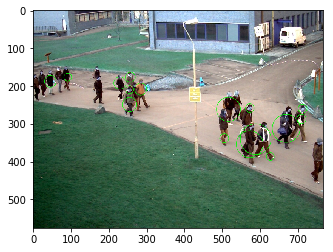

In [296]:
result, image, matrix_codebooks = subtract(DATASET, VIEW, "13-59", 176, matrix_codebooks)
count(image, result)

# Melhorias e problemas